<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Game of Thrones Survival Classification Project**
This is a machine learning classification project on Game of Thrones data. We will classify whether a character is alive or not by the end of book 5. Data contains 1946 characters from the Westeros wiki http://awoiaf.westeros.org, provided in csv format by the A Song of Ice and Data team. The Game of Thrones TV series is based on George RR Martin’s “A Song of Fire and Ice” 7 book series. After the 5th book, the TV series and books diverge more. 

**Plan**:
- Load, explore, clean & visualize the data
- Preprocessing: prepare data for modelling, feature engineering
- 3 models: logistic regression, random forest, __.   

### **SETUP -- Import Libraries, Models & Metrics**
To run this notebook in your browser click the "Open in Colab" button. Below are the libraries, models and metrics we'll use.

In [ ]:
import pandas as pd # data processing
import numpy as np # linear algebra
import seaborn as sns # for visuals
import matplotlib.pyplot as plt # for graphs
# how graphs are printed
%matplotlib inline 
plt.style.use('ggplot') 
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

### **LOAD & EXPLORE DATA**
Use pandas to import the CSV file from a Google Cloud bucket into a dataframe. 

In [ ]:
df_raw = pd.read_csv('https://storage.googleapis.com/storytelling-megano/raw-data/character-predictions.csv', index_col='S.No')
df_raw.head()

,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,DateoFdeath,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,,,,,
1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,NaN,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,105.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,NaN,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 1 to 1946
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   actual             1946 non-null   int64  
 1   pred               1946 non-null   int64  
 2   alive              1946 non-null   float64
 3   plod               1946 non-null   float64
 4   name               1946 non-null   object 
 5   title              938 non-null    object 
 6   male               1946 non-null   int64  
 7   culture            677 non-null    object 
 8   dateOfBirth        433 non-null    float64
 9   DateoFdeath        444 non-null    float64
 10  mother             21 non-null     object 
 11  father             26 non-null     object 
 12  heir               23 non-null     object 
 13  house              1519 non-null   object 
 14  spouse             276 non-null    object 
 15  book1              1946 non-null   int64  
 16  book2              1946 

In [ ]:
df_raw.describe()

,actual,pred,alive,plod,male,dateOfBirth,DateoFdeath,book1,book2,book3,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,433.000000,444.000000,1946.000000,1946.000000,1946.000000,...,23.000000,276.000000,1946.000000,1946.000000,433.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,0.745632,0.687050,0.634470,0.365530,0.619219,1577.364896,2950.193694,0.198356,0.374615,0.480473,...,0.652174,0.778986,0.141829,0.460946,-1293.563510,0.305755,0.074512,0.059096,0.089584,0.745632
std,0.435617,0.463813,0.312637,0.312637,0.485704,19565.414460,28192.245529,0.398864,0.484148,0.499747,...,0.486985,0.415684,0.348965,0.498601,19564.340993,1.383910,0.262669,0.235864,0.160568,0.435617
min,0.000000,0.000000,0.000000,0.000000,0.000000,-28.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-298001.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.391250,0.101000,0.000000,240.000000,282.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.013378,0.000000
50%,1.000000,1.000000,0.735500,0.264500,1.000000,268.000000,299.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.033445,1.000000
75%,1.000000,1.000000,0.899000,0.608750,1.000000,285.000000,299.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,50.000000,0.000000,0.000000,0.000000,0.086957,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,298299.000000,298299.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,100.000000,15.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# check number of rows and columns
df_raw.shape

(1946, 32)

In [ ]:
# Check the total number of missing values in each column
df_raw.isnull().sum()

actual               0
pred                 0
alive                0
plod                 0
name                 0
                    ..
numDeadRelations     0
boolDeadRelations    0
isPopular            0
popularity           0
isAlive              0
Length: 32, dtype: int64

In [ ]:
# Which columns have 70% or more missing values
df_raw.columns[df_raw.isnull().sum() > 1362 ]

Index(['dateOfBirth', 'DateoFdeath', 'mother', 'father', 'heir', 'spouse',
       'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse',
       'age'],
      dtype='object')

Let's work on a subset of the data with characters from the 9 major houses and the Night's Watch. The 9 major houses are: Stark, Arryn, Baratheon, Tully, Greyjoy, Lannister, Tyrell, Martell and Targaryen. 

In [ ]:
# Create a list of the 9 major houses + Night's Watch
major_houses = ['House Stark', 'House Arryn', 'House Baratheon', 'House Tully',
       'House Greyjoy', 'House Lannister', 'House Tyrell', 'House Martell', 
       'House Targaryen', "Night's Watch"]

# Create a dataframe by selecting rows matching major houses
df = df_raw[df_raw['house'].isin (major_houses)]
df.house.unique()

array(['House Arryn', 'House Targaryen', "Night's Watch", 'House Greyjoy',
       'House Stark', 'House Tyrell', 'House Lannister', 'House Martell',
       'House Baratheon', 'House Tully'], dtype=object)

In [ ]:
df.shape

(435, 32)

In [ ]:
df.columns

Index(['actual', 'pred', 'alive', 'plod', 'name', 'title', 'male', 'culture',
       'dateOfBirth', 'DateoFdeath', 'mother', 'father', 'heir', 'house',
       'spouse', 'book1', 'book2', 'book3', 'book4', 'book5', 'isAliveMother',
       'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble',
       'age', 'numDeadRelations', 'boolDeadRelations', 'isPopular',
       'popularity', 'isAlive'],
      dtype='object')

Get rid of prediction scores from source data. We're going to make our own predictions! 

In [ ]:
pred_cols = ['actual','pred','alive', 'plod', 'DateoFdeath']
df.drop(pred_cols, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Drop columns with too many missing values, values not relevant for our analysis (character names), or duplicates/booleans of other columns. A mother, father, spouse or heir's name occurs too infrequently to be useful for prediction of survival. These are also duplicative of the columns that apply more generally: isAliveMother, isAliveFather, isAliveHier, isAliveSpouse. We have columns for age and whether a person is noble or not and house, so drop exact date of birth & title. Boolean columns isPopular and boolDeadRelations are duplicative of popularity and numDeadRelations. 

In [ ]:
cols = ['title', 'dateOfBirth', 'mother', 'father', 'heir', 'spouse', 
        'isPopular', 'boolDeadRelations']
df.drop(cols, axis=1, inplace = True)
df.columns

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['name', 'male', 'culture', 'house', 'book1', 'book2', 'book3', 'book4',
       'book5', 'isAliveMother', 'isAliveFather', 'isAliveHeir',
       'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations',
       'popularity', 'isAlive'],
      dtype='object')

In [ ]:
# Drop the "House" prefix from house names.
df['house'] = df['house'].str.replace(r'House', '')
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,male,culture,house,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,,,
4,Aemma Arryn,0,NaN,Arryn,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
7,Valarr Targaryen,1,Valyrian,Targaryen,0,0,0,0,0,NaN,NaN,NaN,1.0,1,1,26.0,0,0.431438,0
11,Will,1,NaN,Night's Watch,1,1,0,0,0,NaN,NaN,NaN,NaN,0,0,NaN,0,0.163880,0
28,Wulfe,1,Ironborn,Greyjoy,0,0,0,1,1,NaN,NaN,NaN,NaN,0,0,NaN,0,0.023411,1
30,Wyl (guard),0,Northmen,Stark,1,0,0,0,0,NaN,NaN,NaN,NaN,0,0,NaN,0,0.026756,0


### **CHECK FOR MISSING VALUES & OUTLIERS**
Let's explore the data to look for null values & outliers.

In [ ]:
# Check the total number of missing values in each column
df.isnull().sum()

name                  0
male                  0
culture             252
house                 0
book1                 0
book2                 0
book3                 0
book4                 0
book5                 0
isAliveMother       435
isAliveFather       435
isAliveHeir         435
isAliveSpouse       351
isMarried             0
isNoble               0
age                 304
numDeadRelations      0
popularity            0
isAlive               0
dtype: int64

In [ ]:
# Which columns have 80% or more missing values
df.columns[df.isnull().sum() > 348]

Index(['isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse'], dtype='object')

In [ ]:
# Drop columns missing 80% or more
df.drop(['isAliveMother','isAliveFather','isAliveHeir', 'isAliveSpouse'], axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Drop culture, since house has 0 missing values and those correlate
# df.drop(['culture'],axis=1,inplace=True)

Let's take a closer look at the outliers in this age column. From df.describe() we saw the average age is -4359.244275, minimum age -298001 and max age 100. Let's find out which characters are negative ages, then clean up this column by getting rid of the negative values and outliers. 

In [ ]:
df.loc[(df.age <= 0)]

,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
S.No,,,,,,,,,,,,,,,
330,Baelon Targaryen (son of Viserys I),1,Valyrian,Targaryen,0,0,0,0,0,0,1,0.0,0,0.100334,0
791,Mors Martell (brother of Doran),1,NaN,Martell,0,0,0,1,0,0,0,0.0,0,0.066890,0
1685,Doreah,0,Lysene,Targaryen,1,1,0,0,1,0,0,-277980.0,0,0.110368,0
1869,Rhaego,0,NaN,Targaryen,1,1,1,1,0,0,0,-298001.0,6,0.167224,0


After doing a little investigative work on these characters we find
*   Baelon's age should be 44, not 0
*   Doreah was a handmaiden of Daenerys Targaryen who is 25 yrs.
*   Rhaego was the stillborn son of Drogo and Daenerys Targaryen, so 0 yrs makes sense. 
*   Mors Nymeros Martell, brother of Prince Doran Martell died as an infant so no need to change his age of 0yrs. 

In [ ]:
# Set Doreah's age using index
df.at[1685, 'age'] = 25

In [ ]:
# Set Rhaego's age using index value
df.at[1869, 'age'] = 0

In [ ]:
# Set Baelon's age using index
df.at[330, 'age'] = 44

In [ ]:
# Sanity check this took care of all the negative ages
df.loc[(df.age < 0)]

,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
S.No,,,,,,,,,,,,,,,


In [ ]:
df['age'].value_counts()

100.0    11
22.0      7
39.0      5
19.0      5
20.0      5
         ..
1.0       1
46.0      1
54.0      1
9.0       1
12.0      1
Name: age, Length: 63, dtype: int64

In [ ]:
# 11 people exactly 100 yrs old seems odd for Westeros. Who are these characters?
df.loc[(df.age == 100)]

,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
S.No,,,,,,,,,,,,,,,
56,Naerys Targaryen,0,Valyrian,Targaryen,1,0,0,0,0,1,1,100.0,12,0.220736,0
86,Rhaena Targaryen (daughter of Daemon),0,NaN,Targaryen,0,0,0,0,0,1,1,100.0,0,0.143813,0
87,Rhaena Targaryen (daughter of Aegon III),0,Valyrian,Targaryen,0,0,0,0,0,0,1,100.0,0,0.073579,0
286,Aegon Targaryen (son of Jaehaerys I),0,Valyrian,Targaryen,0,0,0,0,0,0,1,100.0,0,0.000000,0
431,Daella Targaryen (daughter of Maekar I),1,Valyrian,Targaryen,0,0,0,0,0,0,1,100.0,0,0.080268,0
432,Daenerys Targaryen (daughter of Aegon IV),0,NaN,Targaryen,0,0,0,0,1,1,1,100.0,10,0.093645,0
434,Daena Targaryen,0,Valyrian,Targaryen,0,0,0,0,0,1,1,100.0,7,0.227425,0
1348,Saera Targaryen,1,Valyrian,Targaryen,0,0,0,0,0,0,1,100.0,0,0.070234,0
1816,Shiera Seastar,0,Westeros,Targaryen,0,0,0,0,1,0,0,100.0,4,0.043478,0


Based on the Wiki of Ice and Fire's data, here are the actual ages. Randomly sampling other ages in the dataset shows other ages do match up with ages listed on the wiki. So it seems the age variable is accurate when it's not listing 100 yrs old or large negative numbers. 
*   Naerys Targaryen: 46
*   Rhaena Targaryen (daughter of Daemon): unknown
*   Rhaena Targaryen (daughter of Aegon III): 24
*   Aegon Targaryen (son of Jaehaerys I): 0
*   Daella Targaryen (daughter of Maekar I): unknown
*   Daenerys Targaryen (daughter of Aegon IV): unknown
*   Daena Targaryen: 26
*   Saera Targaryen: 34
*   Shiera Seastar: 33
*   Rhae Targaryen: unknown
*   Baela Targaryen: unknown

In [ ]:
# Set Naerys's age using index
df.at[56, 'age'] = 46 

In [ ]:
# Set Rhaena's age using index
df.at[87, 'age'] = 24 

In [ ]:
# Set Aegon, son of Jaehaerys I's age using index
df.at[286, 'age'] = 0 

In [ ]:
# Set Daena's age using index
df.at[434, 'age'] = 26 

In [ ]:
# Set Saera's age using index
df.at[1348, 'age'] = 34

In [ ]:
# Set Shiera's age using index
df.at[1816, 'age'] = 33

In [ ]:
# change ages from 100 to NA for: Rhae & Baela Targaryen, 
# Rhaena Targaryen (Daemon), Daella Targaryen & Daenerys Targaryen (Aegon IV) 
df['age'].replace([100], float('NaN'), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
# Verify no one remains listed as 100 incorrectly
df.loc[(df.age == 100)]

,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
S.No,,,,,,,,,,,,,,,


Now that we've dealt with outliers, what does do the mean, median and mode of the age variable look like?

In [ ]:
df['age'].describe()

count    126.000000
mean      32.158730
std       18.860504
min        0.000000
25%       19.000000
50%       28.000000
75%       42.750000
max       84.000000
Name: age, dtype: float64

In [ ]:
df['age'].mode()

0    22.0
dtype: float64

In [ ]:
# check missing values in the dataset
df.isnull().sum()

name                  0
male                  0
culture             252
house                 0
book1                 0
book2                 0
book3                 0
book4                 0
book5                 0
isMarried             0
isNoble               0
age                 309
numDeadRelations      0
popularity            0
isAlive               0
dtype: int64

In [ ]:
# Check for duplicated values
df.duplicated().sum()

0

### **FILL IN MISSING VALUES**

**Age**

Let's fill in missing values for age (309).

In [ ]:
# check distribution of age variable
pd.qcut(df['age'], q=5, precision=0)

S.No
4       (18.0, 24.0]
7       (24.0, 34.0]
11               NaN
28               NaN
30               NaN
            ...     
1928    (18.0, 24.0]
1929             NaN
1932             NaN
1942             NaN
1946    (34.0, 48.0]
Name: age, Length: 435, dtype: category
Categories (5, interval[float64]): [(-1.0, 18.0] < (18.0, 24.0] < (24.0, 34.0] < (34.0, 48.0] <
                                    (48.0, 84.0]]

In [ ]:
df['age'].fillna(22, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# bucket ages into groups
df['age'] = df['age'].astype(int)
df.loc[ df['age'] <= 18, 'age'] = 0
df.loc[(df['age'] > 18) & (df['age'] <= 24), 'age'] = 1
df.loc[(df['age'] > 24) & (df['age'] <= 34), 'age'] = 2
df.loc[(df['age'] > 34) & (df['age'] <= 48), 'age'] = 3
df.loc[(df['age'] > 48) & (df['age'] <= 84), 'age'] = 4

df['age'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

1    336
0     28
4     25
3     24
2     22
Name: age, dtype: int64

### **DATA VISUALIZATION**
Let's create a heatmap to visualize any correlations. The closer to 1 or -1 the correlation value is, the more related the features are. A value close to 0 means there is little correlation. Here are a few questions we could explore.
1. Is there a correlation between a character's traits: **married or not, male or female, noble or not** and survival?
2. Is there a correlation between **popularity** and survival?
3. Is there a correlation between the **number of dead relatives** and that character's survival?
4. Is there a correlation between **appearances in a particular book** & survival?
5. Is there a correlation between **age** & survival?
6. Is there a correlation between whether **mother, father, heir, or spouse are alive** and survival?

In [ ]:
# Create correlation matrix
corr_matrix = df.corr()

# df_dummy = pd.get_dummies(df.house)
# df = pd.concat([df, df_dummy], axis = 1)

# Set up mask to hide upper triangle.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

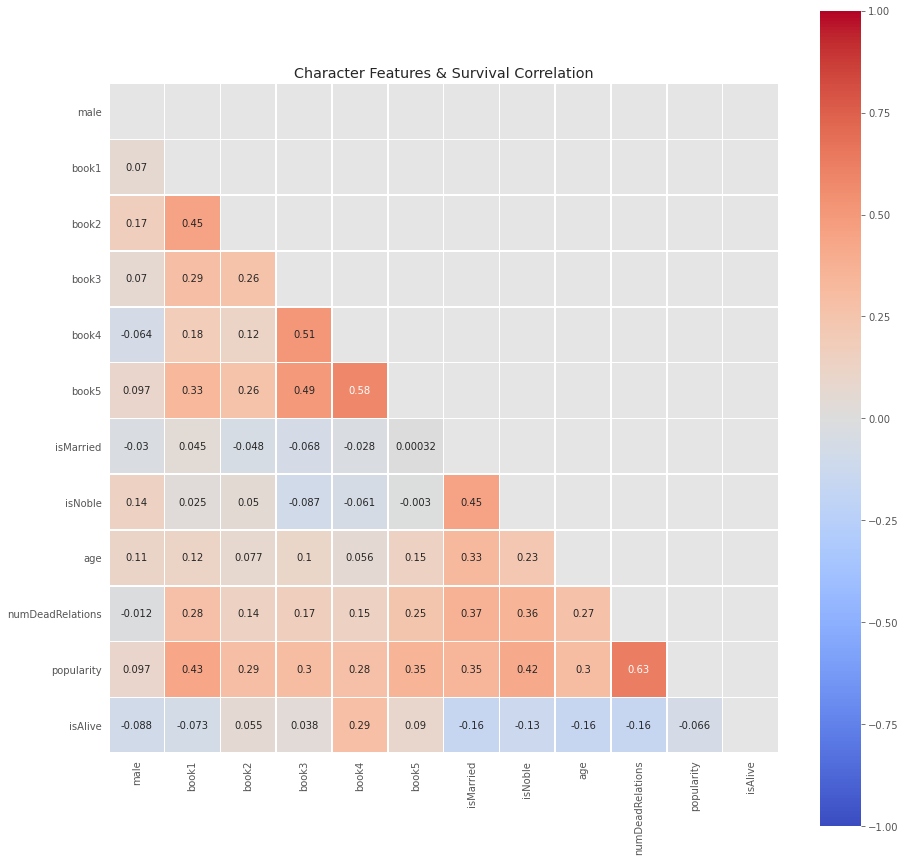

In [ ]:
# Visualize correlations
plt.figure(figsize = (15,15))
sns.heatmap(corr_matrix, 
            mask = mask, 
            square=True, 
            annot=True,
            linewidths = .5, 
            cmap='coolwarm',
            vmin = -1, 
            vmax = 1)

plt.title("Character Features & Survival Correlation")
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Looking at the heatmap above, let's reflect on our initial questions. A strong correlation coefficent is greater than 0.8. A correlation under 0.5 is generally described as weak. There aren't any strong positive or negative correlations between a character's survival and any of the features in our dataframe. The highest correlation 0.63 is between number of dead relatives and popularity. Only the numeric column correlations were calculated, so it's possible there's a correlation between house or culture and survival. 

### **PLOT CLASS BALANCE**
Let's look at the balance of characters alive vs dead and the representation of each house and culture.  

In [ ]:
df.isAlive.value_counts()

1    270
0    165
Name: isAlive, dtype: int64

The dataset isn't heavily skewed in one direction. The living represent 62% of the dataset, and the dead 38%. 

In [ ]:
# What is the representation of each house in the data?
df.house.value_counts() / len(df)

Night's Watch    0.241379
 Stark           0.165517
 Targaryen       0.142529
 Lannister       0.112644
 Greyjoy         0.094253
 Tyrell          0.082759
 Martell         0.066667
 Arryn           0.036782
 Baratheon       0.029885
 Tully           0.027586
Name: house, dtype: float64

Out of 435 characters, Night's Watch represents 24% of the data with 2.8% being from the smallest house, Tully.

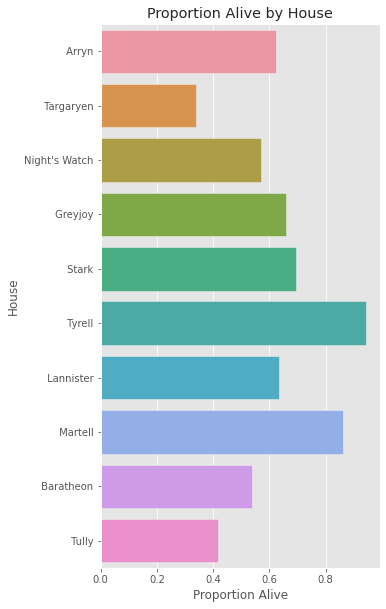

In [ ]:
# Plot proportion alive by house
sns.barplot(x='isAlive', y='house', data=df, ci=None)
fig = plt.gcf()
fig.set_size_inches(5, 10)
plt.xlabel("Proportion Alive")
plt.ylabel("House")
plt.title("Proportion Alive by House")
plt.savefig("proportion_alive_by_house.png", format='png',dpi=150)

House Tyrell has the largest portion alive, while Targaryens have the least portion of their house alive. This matches up with the history of Westeros which inclues a major war between two Targaryens that resulted in the destruction of most of house Targaryen and nearly all their dragons.

In [ ]:
# Get unique culture values regardless 
df['culture'].str.title().unique()

array([nan, 'Valyrian', 'Ironborn', 'Northmen', 'Reach', 'Lhazarene',
       'Westermen', 'Westerman', 'Summer Isles', 'Dothraki', 'Westeros',
       'Rivermen', 'Vale', 'Sistermen', 'Wildling', 'Dorne', 'Dornishmen',
       'Dornish', 'Tyroshi', 'Westerlands', 'Naathi', 'Rhoynar',
       'Free Folk', 'Ironmen', 'Norvos', 'Meereenese', 'First Men',
       'Lysene', 'Pentoshi', 'Valemen', 'Stormlands', 'Braavosi',
       'Wildlings', 'The Reach'], dtype=object)

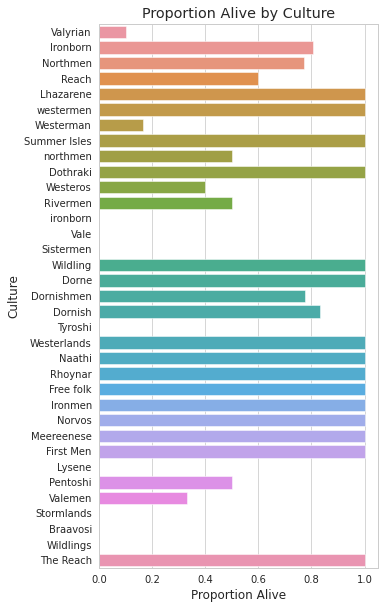

In [ ]:
# Plot proportion alive by culture
sns.set_style('whitegrid')
culture = list(df['culture'].str.title().unique())
ax = sns.barplot(x='isAlive', y='culture', data=df, ci=None)
fig = plt.gcf()
fig.set_size_inches(5, 10)
plt.xlabel("Proportion Alive")
plt.ylabel("Culture")
plt.title("Proportion Alive by Culture")
plt.savefig("proportion_alive_by_culture.png", format='png',dpi=150)

This doesn't seem right. The First Men are the original human inhabitants of Westeros, so it's unlikely they are alive. Let's look at the counts behind these percentages.

In [ ]:
df.loc[df['culture'] == 'First Men'][['name', 'isAlive']]

,name,isAlive
S.No,,
1665,Bran the Builder,1


In [ ]:
df.culture.value_counts()

Northmen      48
Valyrian      29
Ironborn      26
Dornishmen     9
northmen       8
              ..
Lhazarene      1
Dorne          1
First Men      1
Rhoynar        1
Braavosi       1
Name: culture, Length: 35, dtype: int64

In [ ]:
df.culture.nunique()

35

Compared with the house value where we have no null values, the culture value is not likely to be as helpful to predict death. There are 35 unique cultures, and the distribution is sparsely spread across the remaining 32 cultures after the top 3 cultures. There are 19 cultures with just a single person in the culture.

In [ ]:
df.head()

,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
S.No,,,,,,,,,,,,,,,
4,Aemma Arryn,0,NaN,Arryn,0,0,0,0,0,1,1,1,0,0.183946,0
7,Valarr Targaryen,1,Valyrian,Targaryen,0,0,0,0,0,1,1,2,0,0.431438,0
11,Will,1,NaN,Night's Watch,1,1,0,0,0,0,0,1,0,0.163880,0
28,Wulfe,1,Ironborn,Greyjoy,0,0,0,1,1,0,0,1,0,0.023411,1
30,Wyl (guard),0,Northmen,Stark,1,0,0,0,0,0,0,1,0,0.026756,0


##**PREPROCESSING: PREPARE DATA FOR MODELING**
To prepare the data for ML algorithms drop remaining irrelevant columns and convert categorical house values to numeric.

In [ ]:
df.columns

Index(['name', 'male', 'culture', 'house', 'book1', 'book2', 'book3', 'book4',
       'book5', 'isMarried', 'isNoble', 'age', 'numDeadRelations',
       'popularity', 'isAlive'],
      dtype='object')

**Drop columns not useful for ML model**

In [ ]:
df.drop(['culture', 'name'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Turn House Into Numeric Values**

In [ ]:
df_encoded = pd.get_dummies(df)

In [ ]:
df_encoded

,male,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,...,house_ Arryn,house_ Baratheon,house_ Greyjoy,house_ Lannister,house_ Martell,house_ Stark,house_ Targaryen,house_ Tully,house_ Tyrell,house_Night's Watch
S.No,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,1,1,2,0,...,0,0,0,0,0,0,1,0,0,0
11,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
28,1,0,0,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
30,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1,1,1,1,1,1,0,1,1,2,...,0,0,0,0,0,0,0,0,1,0
1929,0,0,0,0,1,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
1932,1,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 4 to 1946
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   male                 435 non-null    int64  
 1   book1                435 non-null    int64  
 2   book2                435 non-null    int64  
 3   book3                435 non-null    int64  
 4   book4                435 non-null    int64  
 5   book5                435 non-null    int64  
 6   isMarried            435 non-null    int64  
 7   isNoble              435 non-null    int64  
 8   age                  435 non-null    int64  
 9   numDeadRelations     435 non-null    int64  
 10  popularity           435 non-null    float64
 11  isAlive              435 non-null    int64  
 12  house_ Arryn         435 non-null    uint8  
 13  house_ Baratheon     435 non-null    uint8  
 14  house_ Greyjoy       435 non-null    uint8  
 15  house_ Lannister     435 non-null    ui

In [ ]:
df_encoded['age'].isnull().sum()

0

In [ ]:
df_encoded.head()

,male,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,...,house_ Arryn,house_ Baratheon,house_ Greyjoy,house_ Lannister,house_ Martell,house_ Stark,house_ Targaryen,house_ Tully,house_ Tyrell,house_Night's Watch
S.No,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,1,1,2,0,...,0,0,0,0,0,0,1,0,0,0
11,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
28,1,0,0,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
30,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


##**MODELING**
Now we can split our data into training and testing sets and build some models. We'll start with a baseline classifer. The baseline is useful to compare with other classifiers. Then we'll do a regression to get a feel for our data before moving to random forest. Since this is a classification problem, we'll use logistic regression instead of linear regression. 

In [ ]:
# define X and y
feature_cols = ['male', 'book1', 'book2', 'book3', 'book4', 'book5', 
                'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity',
                'house_ Arryn', 'house_ Baratheon', 'house_ Greyjoy', 
                'house_ Lannister', 'house_ Martell', 'house_ Stark',
                'house_ Targaryen', 'house_ Tully', 'house_ Tyrell', 
                'house_Night\'s Watch']
X = df_encoded[feature_cols]
y = df_encoded.isAlive.values

Split data into 80% training & 20% testing sets. Use stratified sampling by isAlive status to ensure both training & testing sets contain balanced # of representatives of each of the classes

In [ ]:
# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123456)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(348, 21) (348,)
(87, 21) (87,)


In [ ]:
# scale the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

###**Baseline Classification Model**###
Create a baseline model that always predicts the most common class.

In [ ]:
# create dummy classifier
baseline = DummyClassifier(strategy='most_frequent', random_state=1)

# "train" model
baseline.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=1, strategy='most_frequent')

In [ ]:
# get accuracy score
baseline.score(X_test, y_test)

0.6206896551724138

###**Logistic Regression**###

In [ ]:
# fit the model on the training data
lg = LogisticRegression()

model = lg.fit(X_train, y_train)
predicted = lg.predict(X_test)
# probs = lg.predict_proba(X_test)[:, 1]

In [ ]:
# see what the first 5 predictions are
predicted[0:5]

array([1, 1, 1, 1, 0])

In [ ]:
# view confusion matrix for test data and predictions
confusion_matrix(y_test, predicted)

array([[18, 15],
       [ 8, 46]])

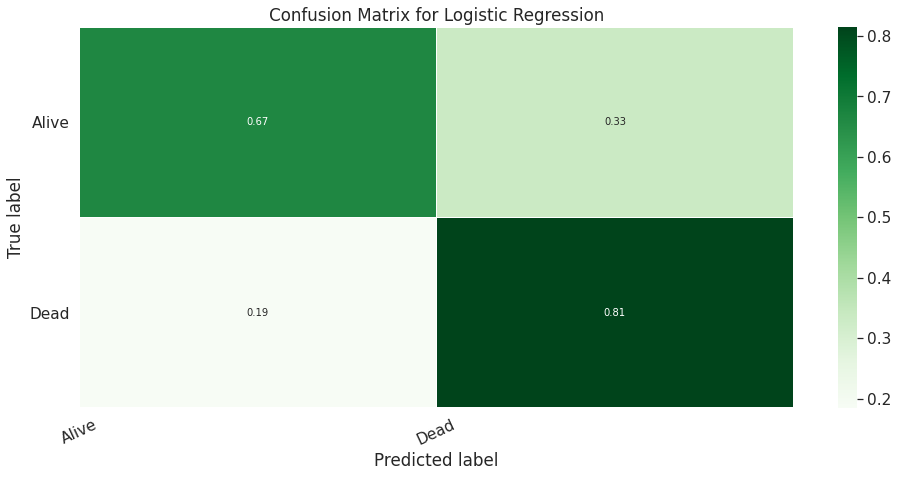

In [ ]:
# get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predicted)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# plot the data
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# add labels to the plot
class_names = ['Alive', 'Dead']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [ ]:
# print accuracy score
print("Score:" , model.score(X_test, y_test))
print(cross_val_score(lg, X, y, cv=10, scoring='accuracy').mean())

Score: 0.735632183908046
0.6918604651162791


In [ ]:
# Try higher number of data splits
lg = LogisticRegression()
logval = cross_val_score(lg, X, y, cv=100).mean()
print(logval)

0.6905000000000001


### **Random Forest Classifier** ###

In [ ]:
# fit random forest classifier to our training set
# rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# predict labels for test data
predicted = rf.predict(X_test)

# evaluate accuracy: % of predictions correct
accuracy = accuracy_score(y_test, predicted)

print(f'Accuracy score: {accuracy:.3}')
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')

Accuracy score: 0.759
Out-of-bag score estimate: 0.767


An accuracy score alone is not a great mesure of classifier performance when the classes are imbalanced. Out of bag (OOB) score is a better estimation of how accurate the model will be when applied to new unseen data. Let's get more information on how the model performed with the different classes. Did it perform better for one class? 

In [ ]:
# view confusion matrix for test data and predictions
confusion_matrix(y_test, predicted)

array([[22, 11],
       [10, 44]])

There aren't high values in the off-diagonals so the model is doing pretty well. Let's make this matrix easier to read by adding some color to help spot the biggest and smallest values. We'll also normalize the values since percents are easier to understand than absolute counts. 

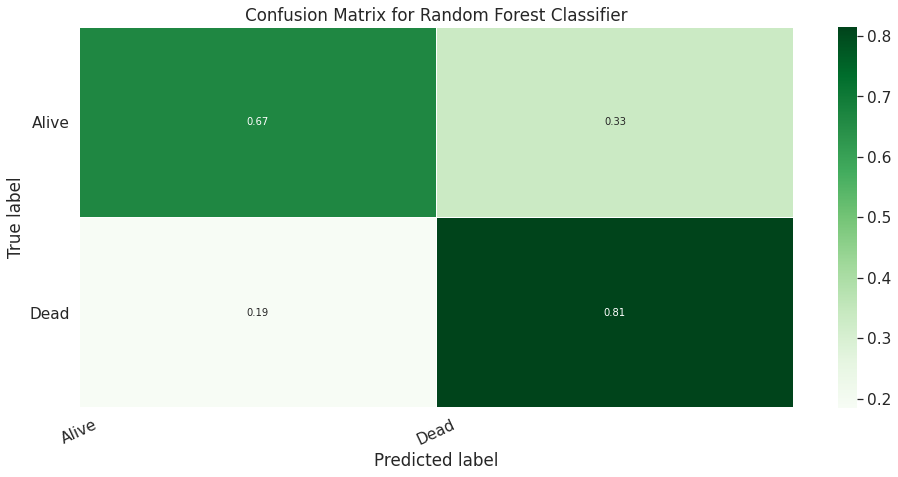

In [ ]:
# get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predicted)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# plot the data
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# add labels to the plot
class_names = ['Alive', 'Dead']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

The classifier had a harder time predicting who would be alive, getting it wrong about a third of the time, while only incorrectly predicting who died 17% of the time. 

#### Classification Report ####
Let's get more insight into model performance by looking at precision, recall and F1 score. Precision is the # of correctly identified / total times the model predicted that class. Recall is the # correctly identified / total # members in that class, or the number of alive characters the model correctly predicted as such. F1 score combines precision and recall into a single metric. If precision & recall are both high, F1 will be high. If they are both low, F1 will be low. If one is high and the other low, F1 will be low. This score is a way to tell if the classifier is actually good at identifying a class, or if it's using shortcuts like classifying everything as a member of a large class.

In [ ]:
# View the classification report for test data and predictions
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68        33
           1       0.80      0.81      0.81        54

    accuracy                           0.76        87
   macro avg       0.74      0.74      0.74        87
weighted avg       0.76      0.76      0.76        87



Looking at class 1 which indicates a character is "alive", both precision and recall are high. Meaning the model was careful to avoid labeling characters alive that died, and it correctly identified many of the total "alive" characters. 